<a href="https://colab.research.google.com/github/Eason0227/Turbofan-Engine-Remaining-Useful-Life-Prediction/blob/main/DL_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA Turbofan Jet Engine DataSet - RUL prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYCARET_CUSTOM_LOGGING_LEVEL'] = 'CRITICAL'

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import  LSTM, Input, Dense, AdditiveAttention, Concatenate

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


E0000 00:00:1751967409.906235   14801 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751967409.909550   14801 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def process_targets(data_length, early_rul):
  early_rul_duration = data_length - early_rul 
  if early_rul_duration <= 0: 
    return np.arange(data_length-1, -1, -1)
  else:
    new_early_rul = early_rul * np.ones(early_rul_duration) 
    origin_rul = np.arange(early_rul-1, -1, -1)
    return np.append(new_early_rul,origin_rul)
  

def process_input_data_with_targets(input_data, target_data , window_length , shift ):
  num_batches = np.int32(np.floor((len(input_data) - window_length)/shift)) + 1
  num_features = input_data.shape[1] 
  output = np.repeat(np.nan, repeats = num_batches * window_length * num_features)
  output_data = output.reshape(num_batches, window_length , num_features)

  if target_data is None: 
    for batch in range(num_batches):
      output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
    return output_data
  else :
    output_targets = np.repeat(np.nan, repeats = num_batches) 
    for batch in range(num_batches):
      window_start = shift * batch
      window_end = window_start + window_length

      output_data[batch,:,:] = input_data[window_start:window_end,:]
      output_targets[batch] = target_data[window_end-1]
    return output_data, output_targets
  

def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):

    max_num_test_batches = np.int32(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1 

    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                          target_data = None,
                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                          target_data = None,
                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [3]:
train_data = pd.read_csv("data/train_FD001.txt", sep= "\s+", header = None)
test_data = pd.read_csv("data/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("data/RUL_FD001.txt", sep = '\s+', header = None)

In [4]:

window_length = 30
shift = 1
early_rul = 125      
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 1     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
#columns_to_be_dropped = [0,1,2,3,4,14,19,20]
#columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,19,20,22,23]
#columns_to_be_dropped = [0,1,2,3,4,14,19,20]




train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
#scaler = StandardScaler()
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data separately as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process training data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed training data shape: ", processed_train_data.shape)
print("Processed training rul shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed training data shape:  (17731, 30, 14)
Processed training rul shape:  (17731,)
Processed test data shape:  (100, 30, 14)
True RUL shape:  (100,)


In [5]:

'''processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                        processed_train_targets,
                                                        test_size = 0.2,
                                                        random_state = 666)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)'''

'processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,\n                                                        processed_train_targets,\n                                                        test_size = 0.2,\n                                                        random_state = 666)\nprint("Processed train data shape: ", processed_train_data.shape)\nprint("Processed validation data shape: ", processed_val_data.shape)\nprint("Processed train targets shape: ", processed_train_targets.shape)\nprint("Processed validation targets shape: ", processed_val_targets.shape)'

## Attention-LSTM

In [6]:


inputs = Input(shape=(30, 14))
lstm_out = LSTM(50, return_sequences=True)(inputs)
attention = AdditiveAttention()([lstm_out, lstm_out])
context = Concatenate()([lstm_out, attention])
lstm_out2 = LSTM(50)(context)
outputs = Dense(96)(lstm_out2)
outputs = Dense(128)(outputs)
outputs = Dense(1)(outputs)


AdditiveAttention_lst_model = Model(inputs, outputs)
AdditiveAttention_lst_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])


AdditiveAttention_lst_model.summary()
#tf.keras.utils.plot_model(AdditiveAttention_lst_model, "my_first_model_with_shape_info.png", show_shapes=True)


I0000 00:00:1751967411.286726   14801 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1058 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 50)    │     13,000 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 30, 50)    │         50 │ lstm[0][0],       │
│ (AdditiveAttention) │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 100)   │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     30,200 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │      4,896 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,416 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,691 (237.07 KB)

 Trainable params: 60,691 (237.07 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def evaluate(true_rul ,pred_rul, model):
  MAE = mean_absolute_error(true_rul, pred_rul)
  RMSE = np.sqrt(mean_squared_error(true_rul, pred_rul))
  r2 = r2_score(true_rul, pred_rul)
  diff = pred_rul - true_rul
  s_score = np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))
  print("Testing : R-square = ",r2,'MAE = ',MAE,"RMSE = ", RMSE,"S-score = ", s_score)

In [8]:
batch_size = 32
epoch = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)


model = AdditiveAttention_lst_model

In [9]:


history_train_loss = []
history_val_loss = []

print("================ Attention-LSTM ================")
start_time = time.time()

model_history = model.fit(processed_train_data, processed_train_targets, epochs=epoch, batch_size=batch_size, validation_data = (processed_test_data, true_rul),
                  callbacks=[early_stopping, reduce_lr])

#model.save('Model_folder/Attention-LSTM_FD001.keras') # Save Model

rul_pred = model.predict(processed_test_data, verbose = 1).reshape(-1)
end_time = time.time()

print('Training : loss = ',model_history.history['loss'][-1])
print('Validation : loss = ',model_history.history['val_loss'][-1])
evaluate(true_rul, rul_pred, "Attention-LSTM")

history_train_loss.append(model_history.history['loss'])
history_val_loss.append(model_history.history['val_loss'])
print( 'Run Time :',int(end_time - start_time),'sec')

================ Attention-LSTM ================
Epoch 1/100


I0000 00:00:1751967413.459379   14866 cuda_dnn.cc:529] Loaded cuDNN version 90300


555/555 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2268.5796 - mean_absolute_error: 37.9907 - root_mean_squared_error: 46.0819 - val_loss: 279.1692 - val_mean_absolute_error: 12.8108 - val_root_mean_squared_error: 16.7084 - learning_rate: 0.0010
Epoch 2/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 253.8570 - mean_absolute_error: 12.1449 - root_mean_squared_error: 15.9279 - val_loss: 262.9903 - val_mean_absolute_error: 12.4793 - val_root_mean_squared_error: 16.2170 - learning_rate: 0.0010
Epoch 3/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 223.5369 - mean_absolute_error: 11.1950 - root_mean_squared_error: 14.9426 - val_loss: 246.0217 - val_mean_absolute_error: 11.0983 - val_root_mean_squared_error: 15.6851 - learning_rate: 0.0010
Epoch 4/100
555/555 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 212.4909 - mean_absolute_error: 10.7825 - root_mean_squared_error: 14.5706 - val_loss: 218.3400 - val_mean_absolute_error: 10.8383 - val_root_mean_squared_error: 14.7763 - learning_rate

## Load Model

In [10]:

model = load_model('Model_folder/Attention-LSTM_FD001.keras')

In [11]:
print("================ Attention-LSTM ================")
rul_pred = model.predict(processed_test_data, verbose = 1).reshape(-1)
end_time = time.time()
evaluate(true_rul, rul_pred, "Attention-LSTM")

================ Attention-LSTM ================
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Testing : R-square =  0.9119573831558228 MAE =  9.492673873901367 RMSE =  12.330374972913688 S-score =  200.70342921424725


## Plot real data and the predicted one to make some comparison

In [12]:
def plot_predActual(y_test, y_predictions,model_name):
  #plt.style.use('seaborn-white')
  plt.rcParams['figure.figsize']=20,5
  fig,ax = plt.subplots()
  plt.title( model_name +' prediction result',fontsize =16)
  plt.ylabel('RUL',fontsize =16)
  plt.xlabel('Test Engine Units',fontsize =16)
  g = sns.lineplot(x = np.arange(0,len(train_data[0].unique())),y = y_test,color='lightseagreen',label = 'actual',ax=ax)
  f = sns.lineplot(x = np.arange(0,len(train_data[0].unique())),y = y_predictions,color='salmon',label = 'predictions',ax=ax)
  ax.grid(True)
  ax.legend()
  plt.show()

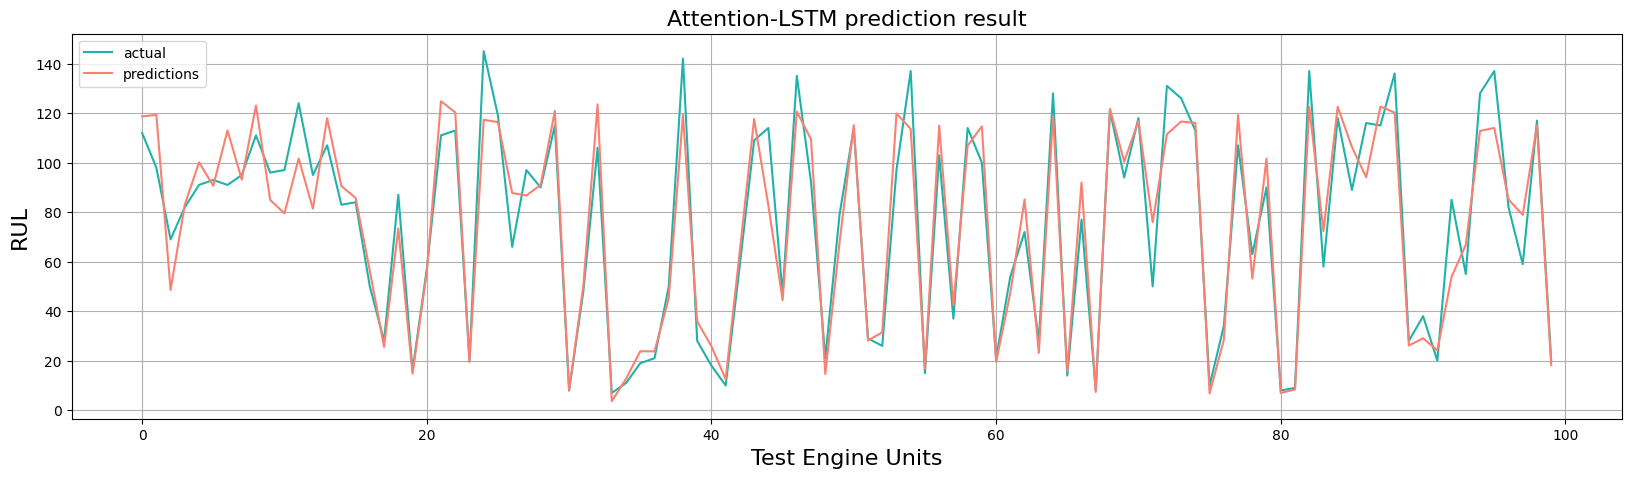

In [13]:
rul_pred = model.predict(processed_test_data,verbose=0).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                            for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
y_true = true_rul.reshape(1,len(true_rul))[0]
plot_predActual(y_true, mean_pred_for_each_engine,"Attention-LSTM")

In [14]:
def Prdection_engine_id(eng_id,model):
    temp_test_data = test_data[test_data[0] == eng_id].drop(columns = [0]).values
    num_wind=len(temp_test_data)
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < num_wind):
         print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
         raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")


    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_wind)

    rul_pred = model.predict(test_data_for_an_engine, verbose = 1).reshape(-1)

    rul = []
    for i in range(num_windows,0,-1):
        if (i<125):
           rul.append(i)
        else:
           rul.append(125)
   
    plt.figure(figsize = (8, 5))
    plt.plot(rul)
    plt.plot(rul_pred)
    plt.ylabel('RUL')
    plt.xlabel('Cycle')
    plt.legend(['actual', 'predictions'])
    plt.title("Engine #"+str(eng_id))
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


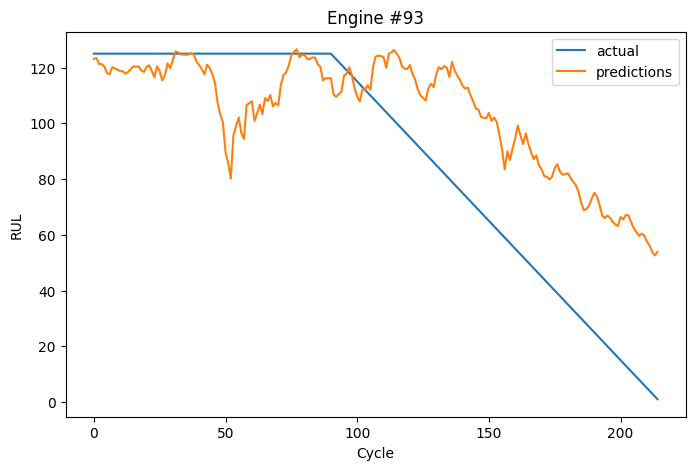

In [15]:
Prdection_engine_id(93,model)